In [2]:
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
from datetime import datetime 
import pandas as pd
import attr
import math
import typing
import xlwings as xw

In [3]:
@attr.s
class HullWhiteProcess:
    sigma: float = attr.ib(default=0.0042)
    mean_rev: float = attr.ib(default=0.03)
    market_curve: ql.YieldTermStructure = attr.ib(default=ql.FlatForward(2, ql.TARGET(), 0.03, ql.Actual360()))
    today_date: ql.Date = attr.ib(default=ql.Date.from_date(datetime.today()))
    
    def alpha(self, t: float) -> float:
        """ 
        This function returns the alpha 
        time-dependent parameter.
        α(t) = f(0, t) + 0.5(σ(1-exp(-kt))/k)^2
        
        Parameters:
        t : reference time in years.
        
        Returns:
        α(t) : deterministic parameter to recover term-rates.
        """
        f = self.market_curve.forwardRate(t, t+0.002739726, ql.Continuous).rate()
        a_t = self.sigma*(1-math.exp(-self.mean_rev*t))
        a_t /= self.mean_rev
        a_t *= a_t
        return f + 0.5*a_t
    
    def gauss_params(self, s: float, t: float, r_s: float) -> typing.Tuple[float, float]:
        """ 
        This function returns the conditional mean
        and conditional variance of the short rate process 
        given the known value
        at time s <= t.
        E{r(t)|r(s)} = (r(s) - α(s))*exp(-k(t-s)) + α(t)
        Var{r(t)|r(s)} = σ^2[1 - exp(-2k(t-s))]/(2k)
        
        Parameters:
        s : information stopping time in years.
        t : reference time in years.
        r_s : short rate known at time s.
        
        Returns:
        E{r(t)|r(s)} : conditional mean
        Var{r(t)|r(s)} : conditional variance
        """
        decay_factor = math.exp(-self.mean_rev*(t-s))
        a_t = self.alpha(t)
        a_s = self.alpha(s)
        E_rt = (r_s - a_s)*decay_factor + a_t
        
        Var_rt = (1 - decay_factor**2)*self.sigma**2
        Var_rt /= 2*self.mean_rev
        
        return E_rt, Var_rt
    
    def short_rate_path(self, path_length: float, 
                        path_steps: float,
                        times: np.array = None) -> typing.Tuple[np.array, np.array]:
        """ 
        This function returns a path drawn from
        the distribution of the conditional short rate.
        
        Parameters:
        path_length : time span in years.
        path_steps : number of steps in the discretized path.
        
        Returns:
        times : array containing the times points in years.
        rt_path : array containing the short rate points.
        """
        if times is None:
            times, dt = np.linspace(start=0.0, stop=path_length, num=path_steps, retstep=True)
        rt_path = np.zeros_like(times)
        rt_path[0] = self.market_curve.forwardRate(0, 0, ql.Continuous).rate()
        for step, tpl in enumerate(zip(times[:-1], times[1:]), 1):
            s, t = tpl
            Et, Vt = self.gauss_params(s, t, rt_path[step-1])
            rt = np.random.normal(loc=Et, scale=math.sqrt(Vt))
            rt_path[step] = rt
        return times, rt_path
    
    def A_B(self, S: float, T: float) -> typing.Tuple[float, float]:
        """ 
        This function returns the time dependent parameters
        of the ZCB, where S <= T.
        B(S, T) = (1 - exp(-k(T-S)))/k
        A(S, T) = P(0,T)/P(0,S) exp(B(S,T)f(0,S) - 
                    σ^2(exp(-kT)-exp(-kS))^2(exp(2kS)-1)/(4k^3))
        
        Parameters :
        S : future reference time of the ZCB in years.
        T : future reference maturity of the ZCB years.
        
        Returns : 
        A(S, T) : scale factor of the ZCB
        B(S, T) : exponential factor of the ZCB
        """
        f0S = self.market_curve.forwardRate(S, S+0.002739726, ql.Continuous).rate()
        P0T = self.market_curve.discount(T, True)
        P0S = self.market_curve.discount(S, True)

        B = 1 - math.exp(-self.mean_rev*(T - S))
        B /= self.mean_rev
        
        exponent = self.sigma*(math.exp(-self.mean_rev*T) - math.exp(-self.mean_rev*S))
        exponent *= exponent
        exponent *= math.exp(2*self.mean_rev*S) - 1
        exponent /= -4*(self.mean_rev**3)
        exponent += B*f0S
        A = math.exp(exponent)*P0T/P0S
        return A, B
    
    def ZCB(self, S: float, T: float, rs: float) -> float:
        """ 
        This function returns the price of a ZCB
        P(S, T) at future reference time S and maturity T 
        with S <= T.
        
        Parameters :
        S : future reference time of the ZCB in years.
        T : future reference maturity of the ZCB years. 
        
        Returns :
        P(S, T) : ZCB price with maturity T at future date S.
        """
        A, B = self.A_B(S, T)
        return A*math.exp(-B*rs)
    
    def future_discount_curve(self, future_date: ql.Date, rt: float) -> ql.YieldTermStructure:
        """ 
        This function returns a Quantlib DiscountCurve
        at a future reference date. The curve is based on 
        160 pillars each at 3m distance.
        
        Parameters :
        future_date : future reference date of the curve.
        rt : short rate at future time t.
        
        Returns :
        QuantLib DiscountCurve object at future reference
        date.
        """
        curve_calendar = self.market_curve.calendar()
        dcf = self.market_curve.dayCounter()
        future_date_t = dcf.yearFraction(self.today_date, future_date)
        final_date = curve_calendar.advance(future_date, ql.Period('40y'), ql.Unadjusted)
        curve_dates = list(ql.MakeSchedule(future_date, final_date, tenor=ql.Period('3m'))) #161
        dts = np.array([dcf.yearFraction(d1, d2) for d1, d2 in zip(curve_dates[:-1], curve_dates[1:])])
        dts = dts.cumsum()
        dts += future_date_t
        future_discount_factors = np.zeros(len(dts)+1)
        future_discount_factors[0] = 1.0
        for ix, t in enumerate(dts):
            future_discount_factors[ix+1] = self.ZCB(future_date_t, t, rt)
        return ql.DiscountCurve(curve_dates, future_discount_factors, dcf, curve_calendar)
    
    def curves_path(self, simulation_dates: typing.List[ql.Date]) -> typing.List[ql.YieldTermStructure]:
        """
        This function returns a list of DiscountCurves at different 
        future dates according to the simulated short rate.
        
        Parameters : 
        simulation_dates : list of future ql.Date at which discount curve 
                           is simulated.
        
        Returns : 
        List of ql.DiscountCurve objects representing the future evolution 
        of the discount curve.
        """
        curve_calendar = self.market_curve.calendar()
        dcf = self.market_curve.dayCounter()
        path_times = [dcf.yearFraction(d1, d2) for d1, d2 in zip(simulation_dates[:-1], simulation_dates[1:])]
        path_times = np.array([0] + path_times).cumsum()
        _, rts = self.short_rate_path(0, 0, path_times.cumsum())
        return [self.future_discount_curve(d, r) for d, r in zip(simulation_dates, rts)]       
    
    def MCsimul(self, Nsimul: int , simulation_dates: typing.List[ql.Date], vanilla_swap: "ql.MakeVanillaSwap", 
                relink_curve: "ql.RelinkableYieldTermStructureHandle()", index: "ql.index"):
        """
        Simulation of the swap for a given number of call dates
        Returns:
        Swap NPV,  Floating Leg NPV,  Fixed Leg NPV, Swap Fair Rate
        """
        Nsimul= Nsimul
        setts = ql.Settings_instance()
        m = len(simulation_dates)
        fixedLegNPV = np.zeros((Nsimul,m))
        floatingLegNPV = np.zeros((Nsimul,m))
        swapNPV = np.zeros((Nsimul,m))
        swapFairRate= np.zeros((Nsimul,m))
        NPV_fixedLeg = []
        NPV_floatingLeg = []
        NPV_swap = []
        swap_fairRate = []
        for path in range(0,Nsimul):
            setts.setEvaluationDate(todayd)
            curve_sim = self.curves_path(simulation_dates)
            fixNPV = []
            floatNPV = []
            swpNPV = []
            swapRate = []
            for ix, d in enumerate(simulation_dates):
                crv = curve_sim[ix]
                relink_curve.linkTo(crv)
                setts.setEvaluationDate(d)
                fixing = crv.zeroRate(0.5, ql.Simple).rate()
                index.addFixing(d, fixing, forceOverwrite=True)
                if d in swap_call_dates:
                    fixNPV.append(vanilla_swap.fixedLegNPV())
                    floatNPV.append(vanilla_swap.floatingLegNPV())
                    swpNPV.append(vanilla_swap.NPV())
                    swapRate.append(vanilla_swap.fairRate())
            NPV_fixedLeg.append(fixNPV)
            NPV_floatingLeg.append(floatNPV)
            NPV_swap.append(swpNPV)
            swap_fairRate.append(swapRate)
        NPV_swap = np.array(NPV_swap).T
        NPV_floatingLeg = np.array(NPV_floatingLeg).T
        NPV_fixedLeg = np.array(NPV_fixedLeg).T
        swap_fairRate = np.array(swap_fairRate).T
        return NPV_swap, NPV_floatingLeg, NPV_fixedLeg, swap_fairRate

In [4]:
calendar = ql.TARGET()
todayd = ql.Date.from_date(datetime.today())
setts = ql.Settings_instance()
setts.setEvaluationDate(todayd)
myhw = HullWhiteProcess(sigma=0.0045, mean_rev=0.03) #, market_curve=eur6m_discount_curve)
# myhw.market_curve = eur6m_discount_curve
myhw.market_curve.enableExtrapolation()

In [5]:
relink_curve = ql.RelinkableYieldTermStructureHandle()
#relink_curve.linkTo(eur6m_discount_curve)
relink_curve.linkTo(myhw.market_curve)
eur6m_index = ql.Euribor6M(relink_curve)
swp_engine = ql.DiscountingSwapEngine(relink_curve)

In [6]:
vanilla_swap = ql.MakeVanillaSwap(ql.Period('15y'), eur6m_index, ql.nullDouble(), ql.Period('0d'), 
                                  fixedLegTenor=ql.Period('12m'),
                                  pricingEngine=swp_engine, Nominal=1e6)

In [7]:
vanilla_swap.fairRate()

0.030907617670763148

In [8]:
swap_fixing_dates = [eur6m_index.fixingDate(d) for d in vanilla_swap.floatingSchedule()]
swap_fixed_schedule = list(vanilla_swap.fixedSchedule())
swap_call_dates = [calendar.advance(d, ql.Period('-2d')) for d in swap_fixed_schedule[:-1]]

In [9]:
simulation_calendar = eur6m_index.fixingCalendar()
simulation_end = simulation_calendar.advance(vanilla_swap.maturityDate(), ql.Period('-1d'))
extra_dates = ql.MakeSchedule(effectiveDate=swap_fixing_dates[0], 
                              terminationDate=simulation_end, 
                              tenor=ql.Period('1w'),
                              calendar=simulation_calendar,
                              convention=eur6m_index.businessDayConvention())

simulation_dates = swap_call_dates +swap_fixing_dates #list(extra_dates) + swap_call_dates

In [10]:
simulation_dates = sorted(set(simulation_dates))

In [11]:
NPV_swap, NPV_floatingLeg, NPV_fixedLeg = myhw.MCsimul(1000, simulation_dates, vanilla_swap, relink_curve, eur6m_index)

C:\Users\J022613\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


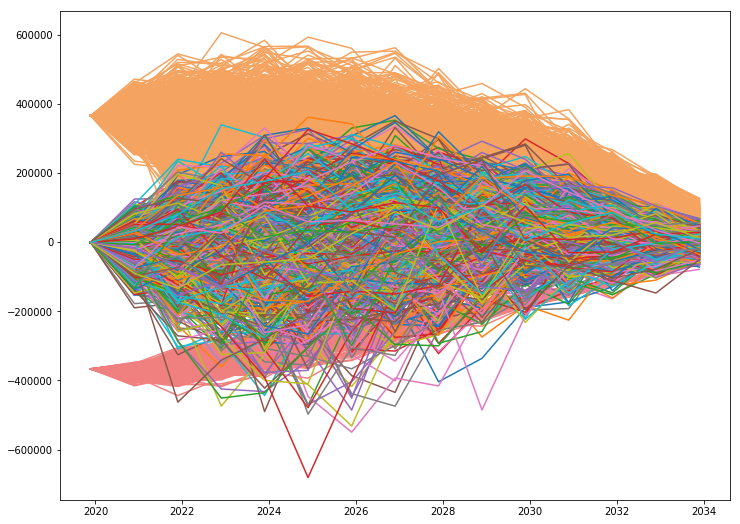

In [12]:
dates_to_plot = [d.to_date() for d in swap_call_dates]
fig = plt.figure(figsize=(12,9))
plt.plot(dates_to_plot,NPV_fixedLeg, color = "lightcoral")
plt.plot(dates_to_plot, NPV_floatingLeg, color = "sandybrown")
plt.plot(dates_to_plot, NPV_swap)
plt.show()

In [483]:
curve_sim = myhw.curves_path(simulation_dates)

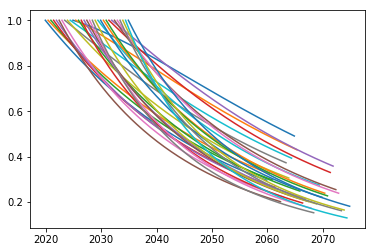

In [484]:
for crv in curve_sim:
    dates, dcfs = zip(*crv.nodes())
    plt.plot([d.to_date() for d in dates], dcfs)
plt.show()

In [582]:
def MCsimul():
    Nsimul= 1000
    m = len(simulation_dates)
    fixedLegNPV = np.zeros((Nsimul,m))
    floatingLegNPV = np.zeros((Nsimul,m))
    swapNPV = np.zeros((Nsimul,m))
    swapFairRate= np.zeros((Nsimul,m))
    NPV_fixedLeg = []
    NPV_floatingLeg = []
    NPV_swap = []
    swap_fairRate = []
    for path in range(0,Nsimul):
        setts.setEvaluationDate(todayd)
        curve_sim = myhw.curves_path(simulation_dates)
        fixNPV = []
        floatNPV = []
        swpNPV = []
        swapRate = []
        for ix, d in enumerate(simulation_dates):
            crv = curve_sim[ix]
            relink_curve.linkTo(crv)
            setts.setEvaluationDate(d)
            fixing = crv.zeroRate(0.5, ql.Simple).rate()
            eur6m_index.addFixing(d, fixing, forceOverwrite=True)
            if d in swap_call_dates:
                fixNPV.append(vanilla_swap.fixedLegNPV())
                floatNPV.append(vanilla_swap.floatingLegNPV())
                swpNPV.append(vanilla_swap.NPV())
                swapRate.append(vanilla_swap.fairRate())
        NPV_fixedLeg.append(fixNPV)
        NPV_floatingLeg.append(floatNPV)
        NPV_swap.append(swpNPV)
        swap_fairRate.append(swapRate)
    NPV_swap = np.array(NPV_swap).T
    NPV_floatingLeg = np.array(NPV_floatingLeg).T
    NPV_fixedLeg = np.array(NPV_fixedLeg).T
    swap_fairRate = np.array(swap_fairRate).T
    return NPV_swap

In [485]:
Nsimul= 1000
m = len(simulation_dates)
fixedLegNPV = np.zeros((Nsimul,m))
floatingLegNPV = np.zeros((Nsimul,m))
swapNPV = np.zeros((Nsimul,m))
swapFairRate= np.zeros((Nsimul,m))
NPV_fixedLeg = []
NPV_floatingLeg = []
NPV_swap = []
swap_fairRate = []
for path in range(0,Nsimul):
    setts.setEvaluationDate(todayd)
    curve_sim = myhw.curves_path(simulation_dates)
    fixNPV = []
    floatNPV = []
    swpNPV = []
    swapRate = []
    for ix, d in enumerate(simulation_dates):
        crv = curve_sim[ix]
        relink_curve.linkTo(crv)
        setts.setEvaluationDate(d)
        fixing = crv.zeroRate(0.5, ql.Simple).rate()
        eur6m_index.addFixing(d, fixing, forceOverwrite=True)
        if d in swap_call_dates:
            fixNPV.append(vanilla_swap.fixedLegNPV())
            floatNPV.append(vanilla_swap.floatingLegNPV())
            swpNPV.append(vanilla_swap.NPV())
            swapRate.append(vanilla_swap.fairRate())

        #fixedLegNPV[path,ix] = vanilla_swap.fixedLegNPV()
        #floatingLegNPV[path,ix] = vanilla_swap.floatingLegNPV()
        #swapNPV[path,ix] = vanilla_swap.NPV()
        #swapFairRate[path,ix] = vanilla_swap.fairRate()
    NPV_fixedLeg.append(fixNPV)
    NPV_floatingLeg.append(floatNPV)
    NPV_swap.append(swpNPV)
    swap_fairRate.append(swapRate)
NPV_swap = np.array(NPV_swap).T
NPV_floatingLeg = np.array(NPV_floatingLeg).T
NPV_fixedLeg = np.array(NPV_fixedLeg).T
swap_fairRate = np.array(swap_fairRate).T

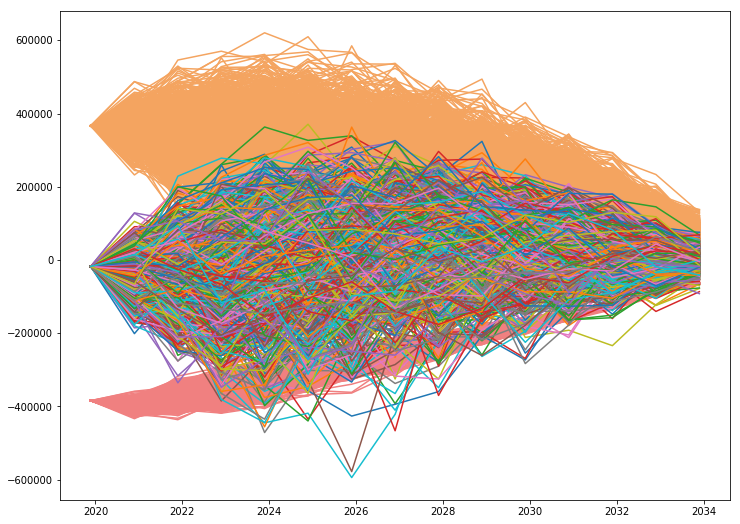

In [624]:
dates_to_plot = [d.to_date() for d in swap_call_dates]
fig = plt.figure(figsize=(12,9))
plt.plot(dates_to_plot,NPV_fixedLeg, color = "lightcoral")
plt.plot(dates_to_plot, NPV_floatingLeg, color = "sandybrown")
plt.plot(dates_to_plot, NPV_swap)
plt.show()

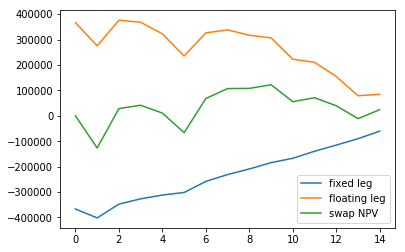

In [487]:
plt.plot(NPV_fixedLeg[:,0], label='fixed leg')
plt.plot(NPV_floatingLeg[:,0], label='floating leg')
plt.plot(NPV_swap[:,0], label='swap NPV')
plt.legend()
plt.show()

In [488]:
NPV_swap[NPV_swap<0] = 0

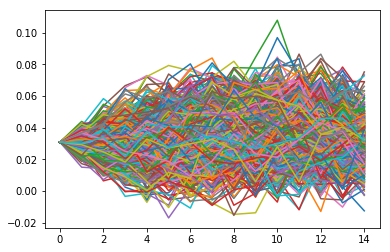

In [489]:
plt.plot(swap_fairRate)
plt.show()

In [490]:
m = len(swap_call_dates) -1
payoff = NPV_swap

In [491]:
V = np.zeros_like(payoff)
V[-1] = payoff[-1]

In [492]:
df = 0.98
for t in range(m-1, 0, -1):
    rg = np.polyfit(swap_fairRate[t,:], V[t+1 ,:]*df, 5)  
    C = np.polyval(rg, NPV_swap[t,:]) 
    V[t,:] = np.where(payoff[t,:] > C, payoff[t,:], V[t+1]* df)

In [493]:
npv_LSM = np.sum(V[1,:]*df) / Nsimul # LSM estimator

In [494]:
npv_LSM

46609.10325797655

In [547]:
lsm2 = [46609]
lsm = [158749, 84738, 68508,46609, 46908, 23290, 420]
mness = ["-150", "-125", "-115", "1", "+115","+125","+150"]

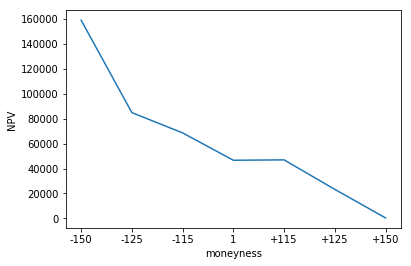

In [548]:
plt.plot(mness, lsm)
plt.xlabel("moneyness")
plt.ylabel("NPV")
plt.show()

In [497]:
#######################################

In [498]:
n = 1  
df = 1
maturity = swap_fairRate[14,:]
reference = swap_fairRate[14 - n,:]
payoff = payoff[14,:]*df

rg   = np.polyfit(reference, payoff, 5)
yy   = np.polyval(rg, reference)

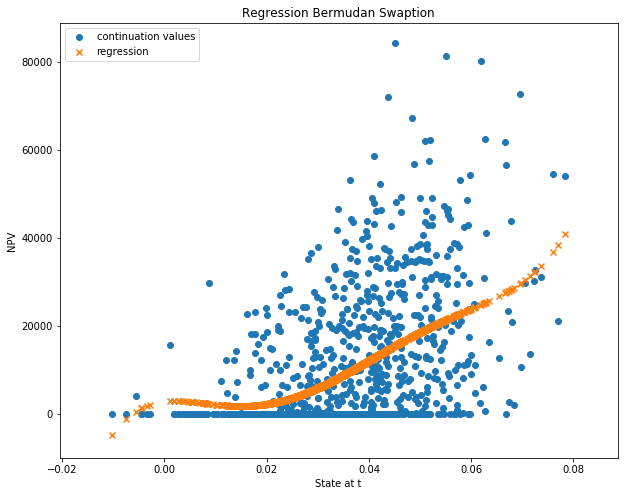

In [503]:
plt.figure(figsize=(10,8))
plt.scatter(reference, payoff)
plt.scatter(reference,yy, marker = "x")
plt.legend(["continuation values", "regression"])
plt.title("Regression Bermudan Swaption")
plt.xlabel("State at t")
plt.ylabel("NPV")
plt.show()

In [500]:
########################à

In [521]:
setts.setEvaluationDate(todayd)
relink_curve.linkTo(myhw.market_curve)
vanilla_swap = ql.MakeVanillaSwap(ql.Period('15y'), eur6m_index, ql.nullDouble(), ql.Period('0d'), 
                                  fixedLegTenor=ql.Period('12m'),
                                  pricingEngine=swp_engine, Nominal=1e6)

In [522]:
vanilla_swap.fairRate()

0.030907511658778627

In [523]:
HWmodel = ql.HullWhite(eur6m_handle, a = 0.03, sigma= 0.0045)

In [533]:
exercise = ql.BermudanExercise(swap_call_dates)

swaption = ql.Swaption(vanilla_swap, exercise)

swaptionEngine = ql.TreeSwaptionEngine(HWmodel, 50)

In [534]:
swaption.setPricingEngine(swaptionEngine)

In [535]:
swaption.NPV()

845.6091509468093

In [550]:
strikes = [-0.0015, -0.00125 ,- 0.001, 0, 0.001 , 0.00125,  0.0015]
mness = ["-150", "-125", "-100", "1", "+100","+125","+150"]

In [564]:
bermudahw = np.zeros(len(strikes))
for i, strike in enumerate(strikes):
    setts.setEvaluationDate(todayd)
    relink_curve.linkTo(myhw.market_curve)
    vanilla_swap = ql.MakeVanillaSwap(ql.Period('15y'), eur6m_index,0.0309 + strike, ql.Period('0d'), 
                                      fixedLegTenor=ql.Period('12m'),
                                      pricingEngine=swp_engine, Nominal=1e6)
    exercise = ql.BermudanExercise(swap_call_dates)
    swaption = ql.Swaption(vanilla_swap, exercise)
    swaptionEngine = ql.TreeSwaptionEngine(HWmodel, 50)
    swaption.setPricingEngine(swaptionEngine)
    bermudahw[i] = swaption.NPV()

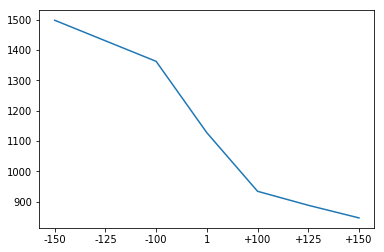

In [565]:
plt.plot(mness, bermudahw)

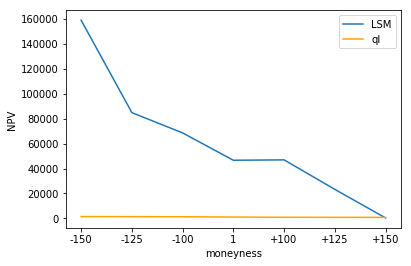

In [566]:
plt.plot(mness, lsm, label = "LSM")
plt.plot(mness, bermudahw, label = "ql", color = "orange")
plt.xlabel("moneyness")
plt.legend()
plt.ylabel("NPV")
plt.show()